In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA





In [2]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
#   'zmomentXX',
#  'zmomentXY',
#  'zmomentYY',
#  'zmomentR1',
#  'zmomentRH',
#  'zPSFFlux',
# #  'zPSFFluxErr',
#  'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
#  'zKronFlux',
# #  'zKronFluxErr',
#  'zKronRad',
# #  'zexpTime',
#   'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
#   'ymomentXX',
#   'ymomentXY',
#   'ymomentYY',
#   'ymomentR1',
#   'ymomentRH',
#   'yPSFFlux',
# #   'yPSFFluxErr',
#   'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
#  'yKronFlux',
# #  'yKronFluxErr',
#  'yKronRad',
# #  'yexpTime',
#   'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
#    'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
#  'zApMag_zKronMag',
#  'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

lc_and_host_features = feature_names_r_g+feature_names_hostgal

In [3]:
dataset_bank_90k = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,)
                                  #)
        
# drop row if any feature values are nan
dataset_bank_90k = dataset_bank_90k[~dataset_bank_90k[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank_90k.drop_duplicates(subset="ztf_object_id", keep='first', inplace=True)
dataset_bank_90k = dataset_bank_90k.set_index('ztf_object_id')
dataset_bank_90k.index.rename("TransientName", inplace=True)
dataset_bank_90k

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,125,129,130,131,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,anom_score,anomaly_score,anomaly_mask,anomaly_type,is_corrected,vpdf_extreme_version,vpdf_extreme_faint,vpdf_extreme_bright,locus_gal_l,locus_gal_b
TransientName,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.881532,-69.513571
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.200342,-26.246909
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352953
ZTF18aczbnhl,97,ANT2019dsk24,85.049145,-11.013302,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,105,12,ztf_candidate:718232301815010005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.961559,-20.751422
ZTF18actbhqt,98,ANT202066j3s,75.082443,-11.302676,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,89,14,ztf_candidate:702289832715010026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.690974,-29.741520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18adairvu,999924,ANT2020ro626,84.348727,-2.927551,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,96,10,ztf_candidate:722282332515010003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.956641,-17.786773
ZTF20aaiwhct,999926,ANT2020pxghw,64.146691,-1.656598,"['dimmers', 'lc_feature_extractor']","['gaia_dr2', 'bright_guide_star_cat', 'allwise']",NaN,86,35,ztf_candidate:1113204944015010026,...,NaN,NaN,NaN,TBD,NaN,NaN,NaN,NaN,194.540371,-34.719753
ZTF20aberawv,999927,ANT2020aebbk,292.910293,54.078978,"['lc_feature_extractor', 'dimmers']",[],NaN,235,96,ztf_candidate:1231482062015010023,...,NaN,0.417276,Fail,TBD,NaN,NaN,NaN,NaN,85.961850,16.149525


In [49]:
%%time

# Instead of above, read in from csv files with host gal info!
# Visually vetted GHOST results split up over XXX files
# So merge them

dfs = []
for start_idx, end_idx in zip(range(0, 72100, 100), range(100, 72200, 100)): #90199, 90299
    df = pd.read_csv(f'./host_info/dataset_bank_hosts_start_idx:end_idx={start_idx}:{end_idx}.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df.drop_duplicates(subset="TransientName", keep='first', inplace=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
#g_hosts_df.reset_index(inplace=True, drop=True)
g_hosts_df

CPU times: user 14.5 s, sys: 1.34 s, total: 15.8 s
Wall time: 17.5 s


,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
TransientName,,,,,,,,,,,,,,,,,,,,,
AT2019ye,PSO J135804.487+203809.056,NaN,NaN,NaN,132762095186853570,916270000024592,143378893266959,0,14931762990582,13276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS18acw,PSO J203708.962-044523.671,NaN,NaN,NaN,102293092873892523,1049658000060517,397026776902759,0,12246887638605,10229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS18kz,PSO J132531.079-142122.461,NaN,NaN,NaN,90772013794782874,1040248000047767,422246824852118,0,11265143992289,9077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SDSS-IISN17461,PSO J034305.548+001507.550,NaN,NaN,NaN,107690557731417905,943938000022176,365716465276576,0,9423182795338,10769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2016ezh,PSO J015804.744+005221.791,NaN,NaN,NaN,106950295197783171,927303000104953,363457312561658,0,8961418540888,10695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acqetxn,PSO J235011.541+191045.231,NaN,NaN,NaN,131013575480825509,1076778000026511,161254547154832,0,13215295323352,13101,...,1.0,11.96380,5.68306,3.76124,3.02015,NaN,NaN,0.0,NaN,NaN
ZTF21acqnurt,PSO J223925.671-022448.679,NaN,NaN,NaN,105103398569764184,1076249000094978,400995326718721,0,12661889120003,10510,...,1.0,15.28430,2.52730,1.53292,1.24170,2.55906,NaN,0.0,False,NaN
ZTF21acqoloi,PSO J231829.296-011726.224,NaN,NaN,NaN,106453496221281681,1082715000043887,401837140257649,0,12704687240487,10645,...,1.0,NaN,9.90200,2.44196,1.46597,3.27679,NaN,0.0,NaN,NaN


In [50]:
len(np.unique(g_hosts_df.index))

19503

In [117]:
# merge ghost info and databank info

# rename as dataset_bank
dataset_bank = pd.merge(dataset_bank_90k, g_hosts_df, left_index=True, right_index=True, how='inner')
dataset_bank.index.rename("ztf_object_id", inplace=True)
dataset_bank.to_csv('../dataframes/dataset_bank.csv')
dataset_bank

,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,1.0,6.10360,4.04109,1.675730,3.49369,29.580500,NaN,0.0,False,NaN
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,1.0,7.05256,1.08888,1.214940,3.95098,1.729270,NaN,0.0,False,NaN
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,1.0,3.99288,1.86034,0.730485,1.92726,1.964520,NaN,0.0,NaN,NaN
ZTF18actbhqt,98,ANT202066j3s,75.082443,-11.302676,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,89,14,ztf_candidate:702289832715010026,...,1.0,NaN,NaN,2.092530,NaN,NaN,NaN,1.0,NaN,NaN
ZTF20aciscxz,100,ANT2020aegc7vi,83.973369,-9.123083,"['lc_feature_extractor', 'high_flux_ratio_wrt_...","['allwise', 'bright_guide_star_cat']",NaN,48,18,ztf_candidate:1356481843915015002,...,1.0,1.05484,1.57786,1.876240,0.98579,1.653290,NaN,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abryurz,817061,ANT2018ghiok,34.680416,29.468295,"['lc_feature_extractor', 'iso_forest_anomaly_d...","['allwise', 'bright_guide_star_cat', '2mass_ps...",NaN,175,9,ztf_candidate:606442754815010556,...,1.0,19.66100,1.96626,2.224410,2.97030,3.066260,NaN,0.0,False,NaN
ZTF18aaokokk,817217,ANT2018jiu2s,273.808976,55.969289,['lc_feature_extractor'],"['gaia_dr2', 'bright_guide_star_cat', '2mass_p...",NaN,267,48,ztf_candidate:569411894515010003,...,1.0,18.39890,1.71872,1.426280,2.42323,12.396400,NaN,0.0,False,NaN
ZTF18ackjnby,817218,ANT2020djewm,311.587364,79.904392,"['lc_feature_extractor', 'iso_forest_anomaly_d...","['bright_guide_star_cat', '2mass_psc', 'allwis...",NaN,490,12,ztf_candidate:941293684915015048,...,1.0,19.90590,1.43737,9.339750,2.86399,1.511130,NaN,0.0,False,NaN


In [118]:
dataset_bank.columns.to_list()

['Unnamed: 0',
 'locus_id',
 'ra',
 'dec',
 'tags',
 'catalogs',
 'ztf_ssnamenr',
 'num_alerts',
 'num_mag_values',
 'oldest_alert_id',
 'oldest_alert_magnitude',
 'oldest_alert_observation_time',
 'newest_alert_id',
 'newest_alert_magnitude',
 'newest_alert_observation_time',
 'brightest_alert_id',
 'brightest_alert_magnitude',
 'brightest_alert_observation_time',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_linear_trend_magn_g',
 'feature_linear_trend_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation

In [121]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features]
dataset_bank_orig.isnull().sum().to_dict() # see which columns have most NaNs

{'feature_amplitude_magn_r': 0,
 'feature_anderson_darling_normal_magn_r': 0,
 'feature_beyond_1_std_magn_r': 0,
 'feature_beyond_2_std_magn_r': 0,
 'feature_cusum_magn_r': 0,
 'feature_inter_percentile_range_2_magn_r': 0,
 'feature_inter_percentile_range_10_magn_r': 0,
 'feature_inter_percentile_range_25_magn_r': 0,
 'feature_kurtosis_magn_r': 0,
 'feature_linear_fit_slope_magn_r': 0,
 'feature_linear_fit_slope_sigma_magn_r': 0,
 'feature_linear_trend_magn_r': 0,
 'feature_linear_trend_sigma_magn_r': 0,
 'feature_magnitude_percentage_ratio_40_5_magn_r': 0,
 'feature_magnitude_percentage_ratio_20_5_magn_r': 0,
 'feature_mean_magn_r': 0,
 'feature_median_absolute_deviation_magn_r': 0,
 'feature_percent_amplitude_magn_r': 0,
 'feature_median_buffer_range_percentage_10_magn_r': 0,
 'feature_median_buffer_range_percentage_20_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_5_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_10_magn_r': 0,
 'feature_period_s_to_n_0_

In [122]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features] #dataset_bank[feature_names_r_g]
# drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]

dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505
ZTF20aciscxz,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,-0.871550,0.001117,...,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062
ZTF18abdkosj,1.776150,-0.175299,0.200000,0.000000,0.353906,3.552299,3.552299,1.268549,2.222622,0.005808,...,0.000200,0.000506,0.001007,7.09951,33.325699,0.687300,0.689600,0.746500,15.107083,4.124426
ZTF18abrcoty,0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,0.004197,...,0.000156,0.000398,0.001222,10.69920,15.298800,1.296299,1.073200,1.217402,20.028593,0.130795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.275452,-0.573414,0.333333,0.000000,0.387438,0.550903,0.521097,0.252838,-0.391557,0.005309,...,0.000014,0.000021,0.000019,2.43244,8.257960,-0.091200,0.001099,-0.079700,11.327088,0.068859
ZTF18abryurz,1.746242,-0.871362,0.500000,0.000000,0.331391,3.492483,3.492483,1.746722,1.320889,-0.007939,...,0.000016,0.000026,0.000026,2.91155,11.302600,-0.118099,-0.075199,0.020201,10.395678,1.697635
ZTF18aaokokk,0.522450,-0.433213,0.142857,0.308607,0.237337,1.044901,0.492287,0.313025,0.784625,0.000321,...,0.000008,0.000011,0.000010,2.57507,8.558080,-0.296700,-0.035900,-0.095200,106.276342,2.499284


In [123]:
dataset_bank_host_ra_dec = dataset_bank[['raMean', 'decMean']]

dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_host_ra_dec, dataset_bank_orig], axis=1)
dataset_bank_orig_host_ra_dec.to_csv('../dataframes/dataset_bank_orig_host_ra_dec.csv')
dataset_bank_orig_host_ra_dec

,raMean,decMean,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,33.970428,-20.262357,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,...,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571
ZTF18acfvwwa,35.632326,32.837878,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,...,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505
ZTF17aaaskvj,28.019186,36.949659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18actbhqt,75.082493,-11.302689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF20aciscxz,83.973390,-9.123059,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,...,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abryurz,34.673140,29.462126,1.746242,-0.871362,0.500000,0.000000,0.331391,3.492483,3.492483,1.746722,...,0.000016,0.000026,0.000026,2.91155,11.302600,-0.118099,-0.075199,0.020201,10.395678,1.697635
ZTF18aaokokk,273.797028,55.979396,0.522450,-0.433213,0.142857,0.308607,0.237337,1.044901,0.492287,0.313025,...,0.000008,0.000011,0.000010,2.57507,8.558080,-0.296700,-0.035900,-0.095200,106.276342,2.499284
ZTF18ackjnby,311.588679,79.899218,1.694893,-0.912100,0.500000,0.000000,0.420127,3.389786,3.389786,2.714476,...,0.000022,0.000029,0.000027,2.56884,5.943030,0.489601,-0.147100,-0.072300,85.712874,1.061153


In [124]:
dataset_bank_catalogs = dataset_bank[['catalogs']]

dataset_bank_orig_catalogs = pd.concat([dataset_bank_catalogs, dataset_bank_orig], axis=1)

# bright_guide_star_cat unfortunately has some non stars that are good galaxies with SN in them...
dataset_bank_orig_catalogs_no_bright_star = dataset_bank_orig_catalogs[~dataset_bank_orig_catalogs['catalogs'].str.contains('bright_guide_star_cat')]
dataset_bank_orig_catalogs_no_bright_star.to_csv('../dataframes/dataset_bank_orig_catalogs_no_bright_guide_star_cat.csv')
dataset_bank_orig_catalogs_no_bright_star

,catalogs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abrcoty,['2mass_xsc'],0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,...,0.000156,0.000398,0.001222,10.69920,15.298800,1.296299,1.073200,1.217402,20.028593,0.130795
ZTF18aatckag,"['allwise', 'gaia_dr2']",0.260850,-0.733969,0.285714,0.000000,0.339135,0.521700,0.483200,0.280875,-0.867793,...,0.000010,0.000017,0.000016,2.79870,10.563600,0.054701,-0.040501,-0.081800,32.328098,18.879176
ZTF18aahqtqd,"['gaia_dr2', 'allwise']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18acdzyog,"['allwise', 'gaia_dr2']",0.429050,-0.728171,0.333333,0.000000,0.383885,0.858101,0.806322,0.340309,0.147949,...,0.000013,0.000017,0.000016,2.36583,3.218680,-0.242901,-0.296499,-0.082100,15.586660,4.995976
ZTF21aasfdps,[],0.077326,-1.108203,0.500000,0.000000,0.368934,0.154652,0.154652,0.096876,0.091439,...,0.000323,0.000871,0.005258,20.48020,29.602800,1.972199,2.030701,1.951900,43.788908,0.946542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaldwzy,[],0.845189,0.214863,0.111111,0.333333,0.317663,1.690378,1.166735,0.204010,2.636375,...,0.000053,0.000096,0.000108,4.57046,17.092199,-0.017000,0.134600,0.132700,10.966393,1.217440
ZTF19abrhnyo,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF17aaakiey,"['gaia_dr2', '2mass_psc', 'allwise']",0.599232,-0.496304,0.166667,0.000000,0.361494,1.198463,1.137587,0.589701,1.046646,...,0.000041,0.000082,0.000131,5.25401,17.667101,0.519400,0.367599,0.500601,27.259273,1.505868


In [126]:
# Choose a dataframe!!

dataset_bank_orig = dataset_bank_orig
#dataset_bank_orig = dataset_bank_orig_catalogs_no_bright_star.drop(columns=['catalogs'])
#dataset_bank_orig = dataset_bank_orig_host_ra_dec.drop(columns=['raMean', 'decMean'])

# Drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]
dataset_bank_orig.to_csv('../dataframes/dataset_bank_orig.csv')
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505
ZTF20aciscxz,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,-0.871550,0.001117,...,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062
ZTF18abdkosj,1.776150,-0.175299,0.200000,0.000000,0.353906,3.552299,3.552299,1.268549,2.222622,0.005808,...,0.000200,0.000506,0.001007,7.09951,33.325699,0.687300,0.689600,0.746500,15.107083,4.124426
ZTF18abrcoty,0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,0.004197,...,0.000156,0.000398,0.001222,10.69920,15.298800,1.296299,1.073200,1.217402,20.028593,0.130795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.275452,-0.573414,0.333333,0.000000,0.387438,0.550903,0.521097,0.252838,-0.391557,0.005309,...,0.000014,0.000021,0.000019,2.43244,8.257960,-0.091200,0.001099,-0.079700,11.327088,0.068859
ZTF18abryurz,1.746242,-0.871362,0.500000,0.000000,0.331391,3.492483,3.492483,1.746722,1.320889,-0.007939,...,0.000016,0.000026,0.000026,2.91155,11.302600,-0.118099,-0.075199,0.020201,10.395678,1.697635
ZTF18aaokokk,0.522450,-0.433213,0.142857,0.308607,0.237337,1.044901,0.492287,0.313025,0.784625,0.000321,...,0.000008,0.000011,0.000010,2.57507,8.558080,-0.296700,-0.035900,-0.095200,106.276342,2.499284


In [130]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,
ZTF20acpdyyq,No_TNS,None,-99.0,None
ZTF18acfvwwa,No_TNS,None,-99.0,None
ZTF17aaaskvj,No_TNS,None,-99.0,None
ZTF18actbhqt,No_TNS,None,-99.0,None
ZTF20aciscxz,No_TNS,None,-99.0,None
...,...,...,...,...
ZTF18abryurz,No_TNS,None,-99.0,None
ZTF18aaokokk,No_TNS,None,-99.0,None
ZTF18ackjnby,No_TNS,None,-99.0,None


In [132]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar # Good
#scaler = preprocessing.MaxAbsScaler() # Create a scalar # Good

# bad scalars
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.2042366  0.36390502 0.44685761 0.52254588 0.58572431 0.62122346
 0.65428704 0.6804875  0.70535427 0.72834677 0.75013114 0.76774561
 0.78303188 0.7979985  0.8114047  0.82351304 0.83494443 0.84579587
 0.85626615 0.866538   0.87602973 0.88483436 0.89323873 0.90078103
 0.90781884]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [133]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.560191,0.424848,0.208939,-0.480166,0.117709,0.045471,0.656289,-0.087108,0.003623,-0.301319,...,-0.180214,0.027189,0.051155,-0.034060,0.168132,-0.075258,-0.040594,-0.096510,0.103022,-0.003183
ZTF18acfvwwa,0.664265,0.530860,-0.016821,0.141054,-0.207320,-0.155166,0.408798,-0.124012,-0.091897,-0.243817,...,0.280133,0.066876,0.071087,-0.067119,0.149576,-0.016245,0.009130,0.076452,0.230596,0.003926
ZTF20aciscxz,-0.291376,-0.722325,-0.097066,-0.205800,-0.198076,-0.267756,-0.116519,-0.296296,-0.044383,0.336848,...,0.092750,0.004988,0.052891,0.010582,0.222774,-0.224389,-0.032595,0.170507,-0.078600,-0.038215
ZTF18abdkosj,0.036447,1.273626,-0.230454,-0.084489,0.815456,0.160490,-0.444912,0.634306,-0.070800,0.301928,...,0.135030,-0.340540,0.065726,0.033966,0.167821,-0.090478,-0.065983,0.086221,0.097391,-0.101308
ZTF18abrcoty,-0.482680,-0.713043,-0.354130,0.021683,0.668199,0.463253,-0.151325,-0.294039,0.541762,0.004816,...,-0.196776,-0.237810,-0.218477,0.072328,0.113456,-0.279820,0.000936,0.095940,0.333679,0.123281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.046297,-0.396499,-0.323047,0.426791,0.698077,-0.516206,0.455113,0.394533,-0.352151,-0.183416,...,0.088048,-0.046945,0.094806,-0.125152,-0.287122,-0.138632,0.057639,0.135672,-0.086079,0.068206
ZTF18abryurz,-1.094431,1.356183,0.220728,-0.625607,-0.349834,-0.191420,0.035171,0.488645,-0.265976,-0.293051,...,-0.278539,0.114889,0.149895,-0.184241,0.060488,0.139087,0.049290,0.410414,-0.130977,-0.038390
ZTF18aaokokk,0.518545,0.281588,0.267236,-0.394557,-0.296436,-0.007817,-0.096800,-0.437333,-0.081835,0.070233,...,-0.190652,0.139196,-0.100896,0.031541,0.179606,0.058744,-0.001191,-0.150557,-0.004577,-0.190810


In [234]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()

# for Lc + host features 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aciwhcb'] # Ia
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpdyyq'] # star - weird that it has host info (CHECK INTO THIS)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuyayk'] # RRyl kinda star behavior 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvmlow'] # close SN (many ANNs are HII regions) [cool first match]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvbbvs'] # variable - check host info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20actvmqi'] #SN Ia w/ small ANN=1 dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaxksct'] # SN Ia, z=0.1 w/ small ANN=1 dist (cool example through first few ANN)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwnrty'] # SN Ia  #good one
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpjcoe'] # SN Ia, z=0.04
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadoota'] # IIn, z=0.058
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abywydb'] #II, z=0.04 no apparent host
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwobku'] #2020acct (matches to a couple IIb)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabxjqr'] # IIb, z=0.03
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19ackwoak'] # star (check host) (finds other stars)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvlumw'] # central bogus obs in bright gal core (check host) (finds more bogus)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aacoati'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18ablgnri'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagtqna'] # long lived IIP, closeby (finds more IIs)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acrjydf'] #CV/nova in M31 (check host in GHOST) [finds nova!]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aamzgzi'] # bogus core obs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abowuqe'] #SN Ia w/ small ANN=1 dist (wow, good matches)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] #SN Ia w/ small ANN=1 dist, z=0.084
dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aabyyhr'] # SN Ia w/ missed TNS ANNs and good matches!

# NOTE: all stars are misassociations


# for host features only
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19aabyyhr,-0.770877,-0.16583,0.289,0.582857,-0.136818,-0.283026,-0.000866,-0.057971,-0.19394,-0.022163,...,-0.020546,0.030939,-0.018385,-0.094854,-0.206571,-0.134036,-0.053836,0.04789,-0.021095,-0.146408


In [235]:
dataset_bank_tns_df

,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,
ZTF20acpdyyq,No_TNS,None,-99.0,None
ZTF18acfvwwa,No_TNS,None,-99.0,None
ZTF17aaaskvj,No_TNS,None,-99.0,None
ZTF18actbhqt,No_TNS,None,-99.0,None
ZTF20aciscxz,No_TNS,None,-99.0,None
...,...,...,...,...
ZTF18abryurz,No_TNS,None,-99.0,None
ZTF18aaokokk,No_TNS,None,-99.0,None
ZTF18ackjnby,No_TNS,None,-99.0,None


In [236]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = f'https://alerce.online/object/{ztf_id}'
print(link_ref)
print("%%%%%%")
#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

ZTF ID name (ref) ZTF19aabyyhr
https://alerce.online/object/ZTF19aabyyhr
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aabyyhr		Yes_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=187.57776724+11.75541104&filter=color

ANN=1	https://alerce.online/object/ZTF20actvmqi		Yes_TNS		None		z=-99.0			d=0.4607	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=169.89174186+53.58845338&filter=color

ANN=2	https://alerce.online/object/ZTF20acfnuee		Yes_TNS		SN Ia		z=0.06			d=0.468	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=337.90234907+2.5017566&filter=color

ANN=3	https://alerce.online/object/ZTF21abowuqe		Yes_TNS		None		z=-99.0			d=0.4754	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=263.18890058+37.09332029&filter=color

ANN=4	https://alerce.online/object/ZTF18abmofew		No_TNS		None		z=-99.0			d=0.5007	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=346.28032396+22.72115632&filter=color

ANN=5	https://alerce.online/object/ZTF20acpevlh		Yes_TNS		None		z=-

# TODO: use antares_client to get lc info, and make plot of ref and ANNs, and then thumbnails of host gal.

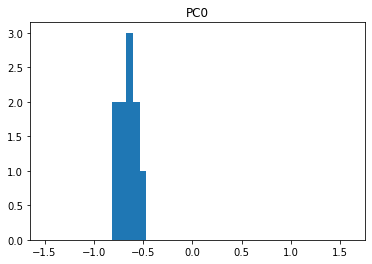

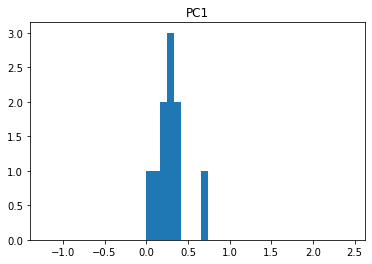

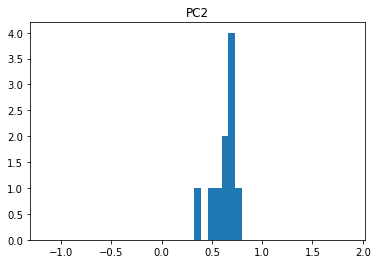

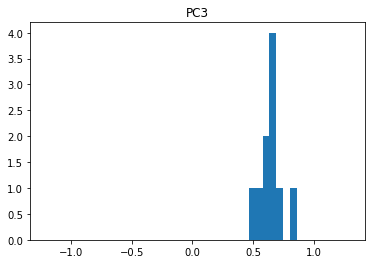

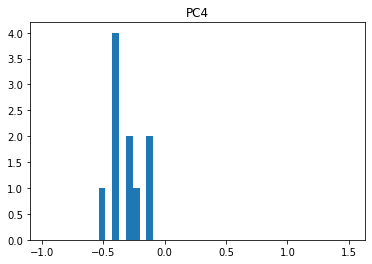

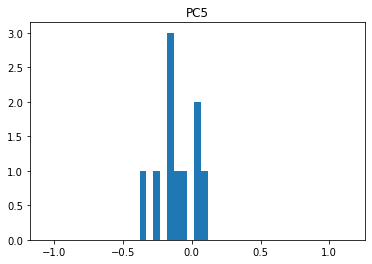

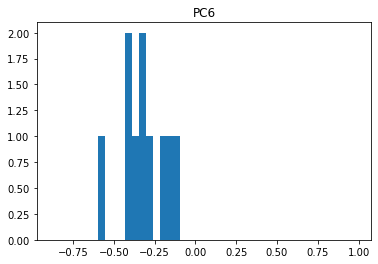

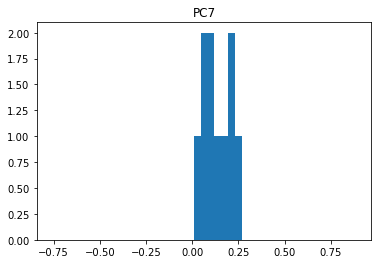

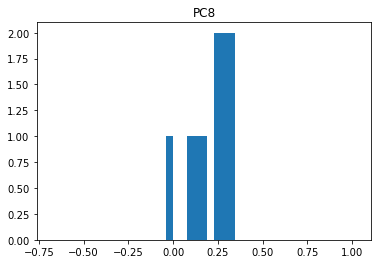

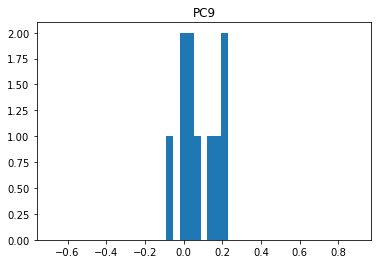

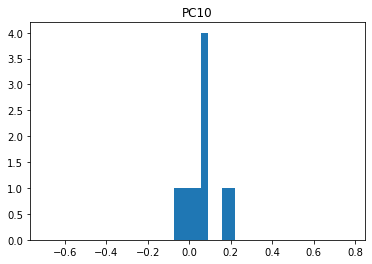

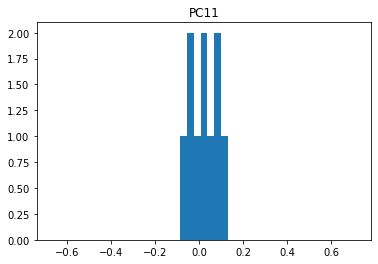

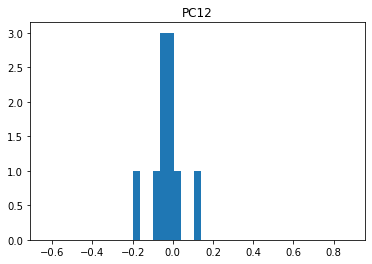

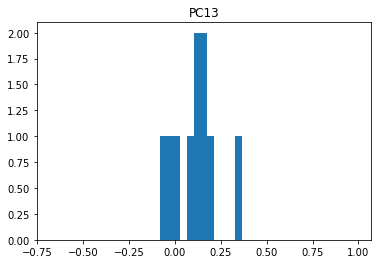

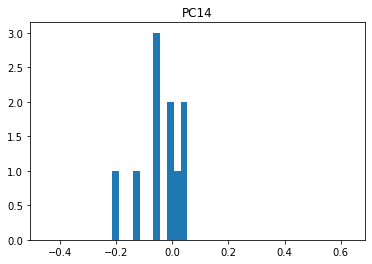

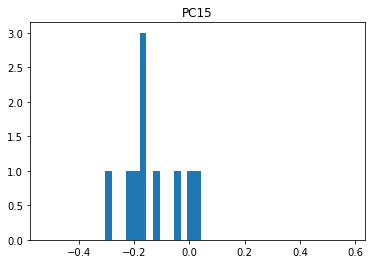

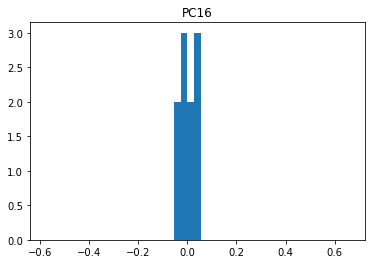

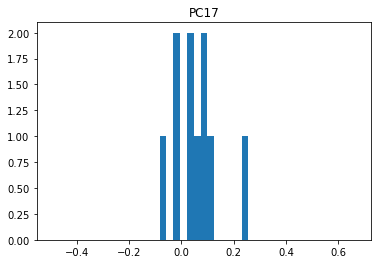

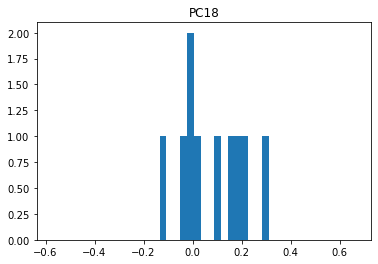

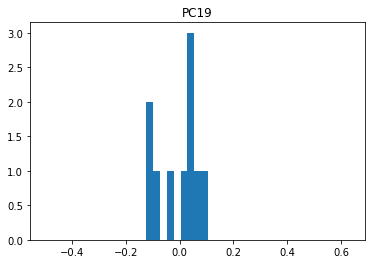

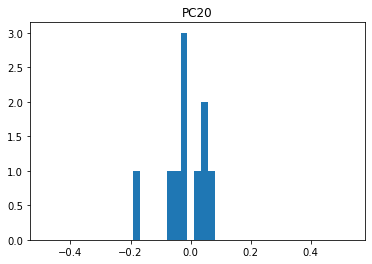

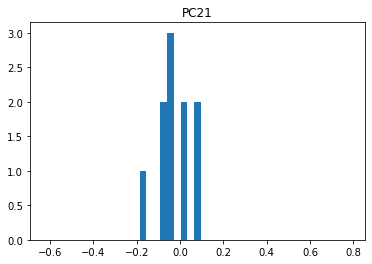

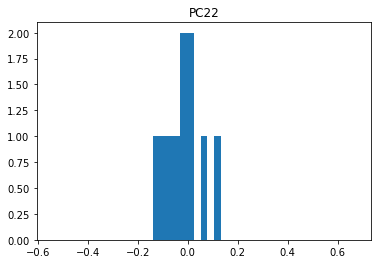

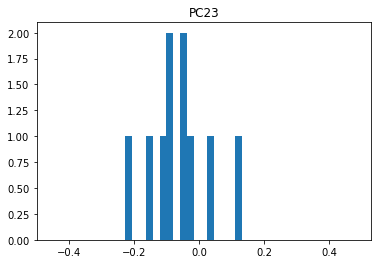

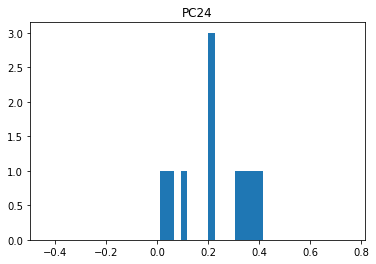

In [237]:
feat_scatter_l = []
for feat in results_df.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(results_df[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(results_df[feat])
    feat_scatter_l.append(feat_scatter)    

In [238]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.09321344174108609
Scatter median: 0.0903381086358831
Scatter std: 0.028674392190345396
Scatter max: 0.17128857427818187
Scatter min: 0.031802225754456195


In [239]:
list(np.unique(dataset_bank_orig.index))

['ZTF17aaaazmz',
 'ZTF17aaabghb',
 'ZTF17aaabuab',
 'ZTF17aaaceht',
 'ZTF17aaadqdy',
 'ZTF17aaadqyf',
 'ZTF17aaadvbj',
 'ZTF17aaadvbq',
 'ZTF17aaaeqwm',
 'ZTF17aaaesne',
 'ZTF17aaaessf',
 'ZTF17aaaeszu',
 'ZTF17aaafssi',
 'ZTF17aaafstx',
 'ZTF17aaafvft',
 'ZTF17aaafvwp',
 'ZTF17aaahfef',
 'ZTF17aaahmid',
 'ZTF17aaaikkq',
 'ZTF17aaaiujz',
 'ZTF17aaajigm',
 'ZTF17aaajtpw',
 'ZTF17aaakiey',
 'ZTF17aaanjkj',
 'ZTF17aaaosws',
 'ZTF17aaarsja',
 'ZTF17aaastat',
 'ZTF17aaaszpi',
 'ZTF17aaategd',
 'ZTF17aaatkcm',
 'ZTF17aaatuke',
 'ZTF17aaatukm',
 'ZTF17aaatuld',
 'ZTF17aaatuyr',
 'ZTF17aaatvkt',
 'ZTF17aaatxik',
 'ZTF17aaatxjg',
 'ZTF17aaatyyh',
 'ZTF17aaawdfs',
 'ZTF17aaaweop',
 'ZTF17aaawfja',
 'ZTF17aaaxbgi',
 'ZTF17aaaxbpe',
 'ZTF17aaaxcuq',
 'ZTF17aaaxddg',
 'ZTF17aaaxdrt',
 'ZTF17aaaxehr',
 'ZTF17aaaxepf',
 'ZTF17aaaxepp',
 'ZTF17aaaxfzx',
 'ZTF17aaaxklm',
 'ZTF17aaaxpie',
 'ZTF17aaayhze',
 'ZTF17aaayial',
 'ZTF17aaaylgr',
 'ZTF17aaaylji',
 'ZTF17aaayqxe',
 'ZTF17aaazdba',
 'ZTF17aaazmzw

In [240]:
%%time

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index)):
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, 10)]
# sum specific columns
ann_dist_all_df[f'Mean_{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))

# weighted distance of first 9 ANNs
weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
ann_dist_all_df[f'WeightedMean_{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df

CPU times: user 28.9 s, sys: 324 ms, total: 29.3 s
Wall time: 29.7 s


,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9,Mean_9ANNs,WeightedMean_9ANNs
key_0,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaazmz,9270,4192,10845,3554,14155,5249,13778,10107,13738,14386,...,0.684075,0.739416,0.754693,0.773463,0.785209,0.813653,0.818126,0.818618,0.760387,0.702435
ZTF17aaabghb,7722,8338,10671,2010,11726,2260,13693,7514,11832,408,...,0.561794,0.581010,0.582323,0.650664,0.656208,0.681476,0.682193,0.702437,0.625285,0.567960
ZTF17aaabuab,13751,12692,2743,1948,2453,3868,5936,13717,6465,6671,...,0.739979,0.778462,0.784660,0.792272,0.797418,0.807016,0.810898,0.820131,0.782254,0.746099
ZTF17aaaceht,2529,7553,14916,7966,9586,8439,256,10965,14471,7424,...,0.735813,0.767513,0.836007,0.858163,0.859719,0.878086,0.880206,0.883346,0.817013,0.735822
ZTF17aaadqdy,5152,14450,11858,2734,6146,7790,11167,1491,10912,8767,...,0.819539,0.825003,0.846223,0.853544,0.854030,0.854111,0.863498,0.870171,0.832390,0.783637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acogvaq,8538,4402,3094,2775,10805,5758,13647,11400,4803,10862,...,0.643185,0.704918,0.728677,0.733509,0.764000,0.771798,0.790161,0.790828,0.723049,0.651326
ZTF21acowflo,7520,7917,9282,4441,9514,10712,10335,9497,8213,11077,...,0.717610,0.757470,0.762150,0.770932,0.773266,0.777917,0.797282,0.805162,0.756553,0.708538
ZTF21acqdfea,7770,1487,8129,9355,2912,8356,5049,1729,1147,4428,...,0.580611,0.600261,0.610840,0.621848,0.628064,0.639629,0.644221,0.671345,0.618411,0.588784


In [241]:
# Pick distance metric. 
# Weighted mean of first 9 ANNs (Fibonacci), OR Mean of first 9 ANNs, OR distance to first ANN. 
# TODO: EXPLORE DIFFERENT METRICS!
dist_col = f'WeightedMean_{len(col_list)}ANNs'  # f'Mean_{len(col_list)}ANNs' # 'dist=1'

print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of mean distance of 9 ANNs
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.6794546253521007
Scatter median: 0.6730218489061703
Scatter std: 0.13062128765144485
Scatter max: 1.6532873958349228
Scatter min: 0.35466017946600914


Most anomalous: ZTF19aaeyltm


# Largest distance


### either bogus (bright "obs" at core which aren't real)
### intense variable star
### bright/ nearby SN
### big gaps
### quick rise and then no obs until much later
### some truly weird ones (20acct)

In [242]:
ref_obj = ann_dist_all_df[[dist_col]].idxmax().values[0] #'ZTF18acbwaxk'
print("Max dist", ann_dist_all_df.loc[ref_obj][dist_col]) 

Max dist 1.6532873958349228


In [243]:
dataset_bank[dataset_bank.index == ref_obj]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19aaeyltm,-0.426498,1.38195,0.760668,-0.487392,0.986068,0.418826,-0.52242,-0.081831,-0.02066,0.332683,...,0.063113,0.111222,0.706139,0.051809,0.406727,-0.026693,0.68348,0.355435,-0.176884,-0.142045


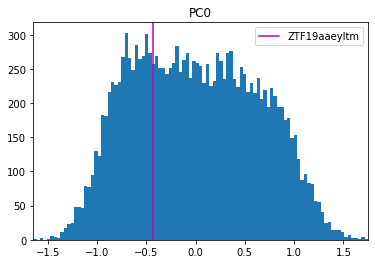

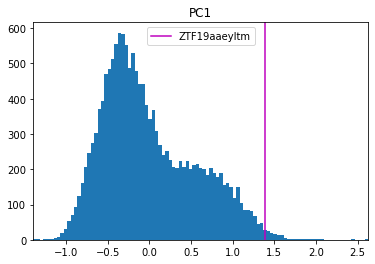

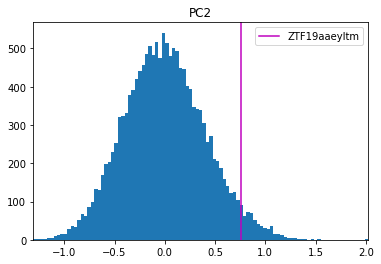

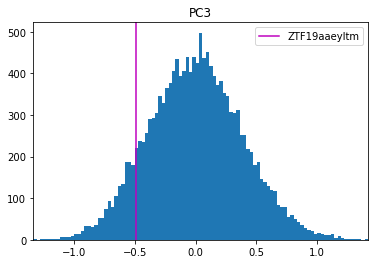

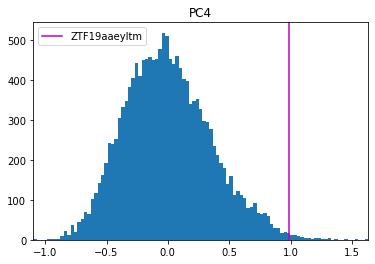

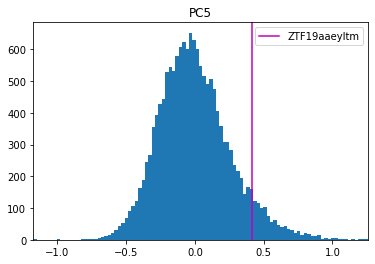

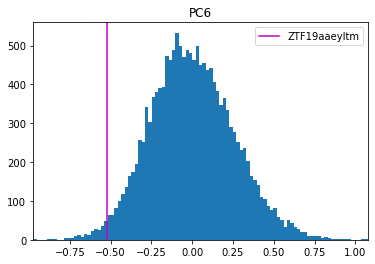

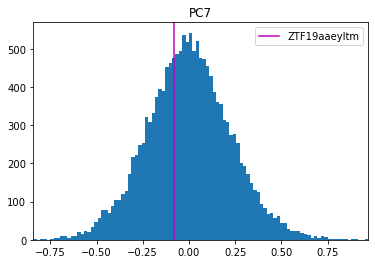

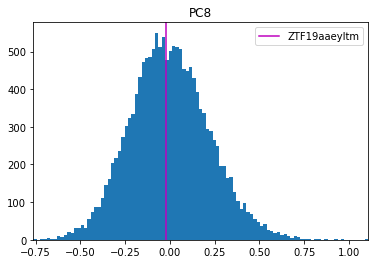

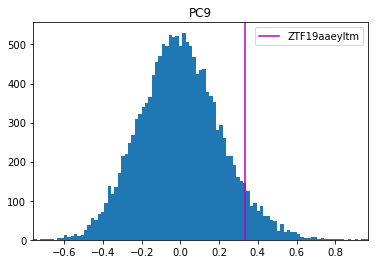

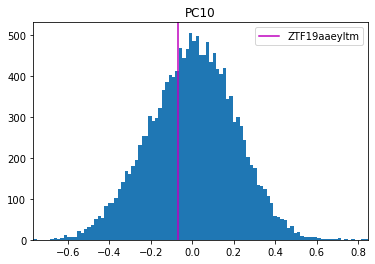

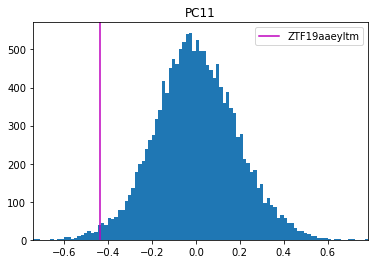

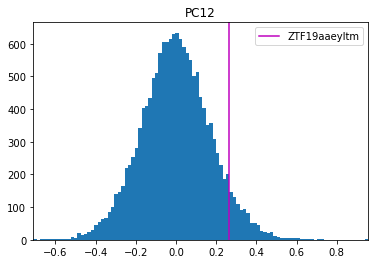

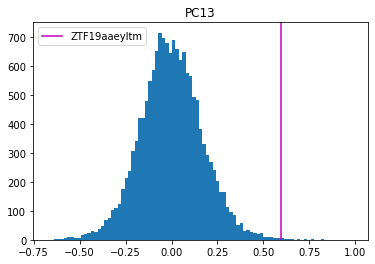

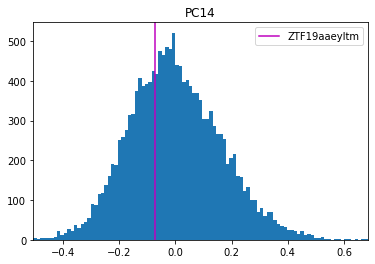

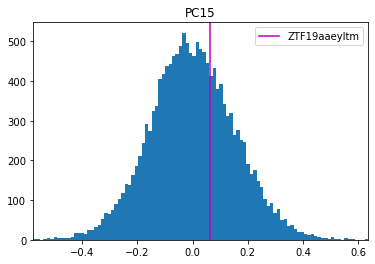

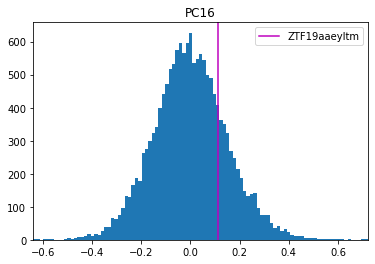

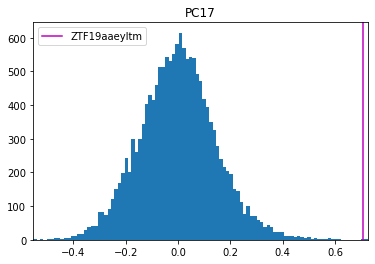

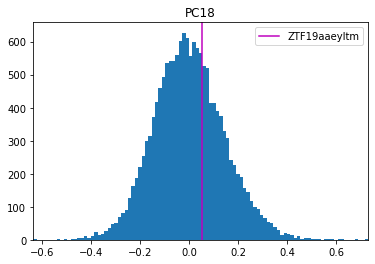

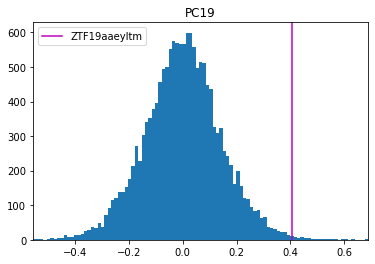

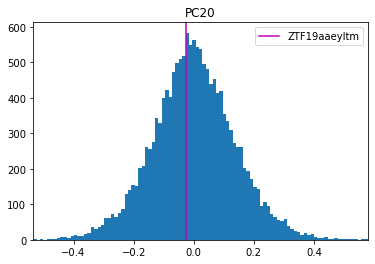

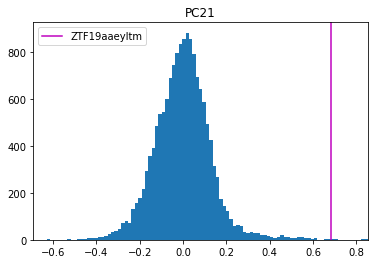

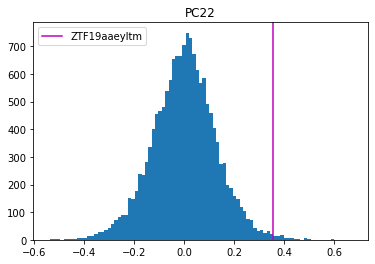

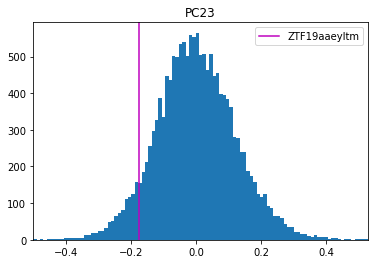

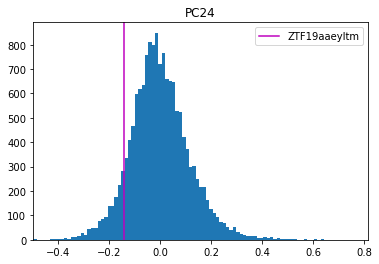

In [244]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [245]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[-0.4264976330857314 1.3819498446766194 0.7606675321172354
 -0.4873924922588462 0.9860675775432395 0.4188256118330677
 -0.5224202564412892 -0.0818307530547836 -0.02066006711914413
 0.3326827531754378 -0.06957726717894791 -0.43462600251638667
 0.26278834179195887 0.5973681898733881 -0.0731736282901785
 0.06311288835198071 0.11122194250552457 0.7061385947605322
 0.051808550653425586 0.40672684050965807 -0.02669263758137467
 0.6834798673434991 0.3554347740746215 -0.17688388729513155
 -0.142044795052677]
ZTF ID name (ref) ZTF19aaeyltm
https://alerce.online/object/ZTF19aaeyltm
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aaeyltm		No_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=164.00618542+57.11700351&filter=color

ANN=1	https://alerce.online/object/ZTF20acijzic		No_TNS		None		z=-99.0			d=1.6377	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=21.12828305+-15.53785961&filter=color

ANN=2	https://alerce.online/object/ZTF18ackwokk		No_TNS		None		z=-99.0			d=

In [246]:
ann_dist_all_df.loc[ref_obj]

ann=0                  3677.000000
ann=1                 14151.000000
ann=2                  8849.000000
ann=3                  7628.000000
ann=4                  9648.000000
ann=5                 11737.000000
ann=6                  5658.000000
ann=7                 12057.000000
ann=8                  8660.000000
ann=9                  9486.000000
dist=0                    0.000000
dist=1                    1.637708
dist=2                    1.640410
dist=3                    1.652742
dist=4                    1.666687
dist=5                    1.694632
dist=6                    1.704765
dist=7                    1.728317
dist=8                    1.732929
dist=9                    1.762433
Mean_9ANNs                1.691180
WeightedMean_9ANNs        1.653287
Name: ZTF19aaeyltm, dtype: float64

In [247]:
# 100 largest distances
ann_dist_all_df[dist_col].nlargest(100)

key_0
ZTF19aaeyltm    1.653287
ZTF21acbalhp    1.619047
ZTF18abtteya    1.538039
ZTF21aaxntve    1.492059
ZTF18abvmlow    1.457726
                  ...   
ZTF20acjqkmg    1.069358
ZTF19aabymti    1.068654
ZTF18abuipdd    1.067694
ZTF18abvtjgy    1.067226
ZTF20acotuvr    1.064611
Name: WeightedMean_9ANNs, Length: 100, dtype: float64

In [248]:
# 100 largest distances objs 
for ztfid in list(ann_dist_all_df[dist_col].nlargest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF19aaeyltm

https://alerce.online/object/ZTF21acbalhp

https://alerce.online/object/ZTF18abtteya

https://alerce.online/object/ZTF21aaxntve

https://alerce.online/object/ZTF18abvmlow

https://alerce.online/object/ZTF20abfehpe

https://alerce.online/object/ZTF18abvbbvs

https://alerce.online/object/ZTF20abeywdn

https://alerce.online/object/ZTF20acqucpz

https://alerce.online/object/ZTF18aabjliz

https://alerce.online/object/ZTF21aaaadvr

https://alerce.online/object/ZTF21aaaodzf

https://alerce.online/object/ZTF20ablygyy

https://alerce.online/object/ZTF21aabpszb

https://alerce.online/object/ZTF18aaqvatw

https://alerce.online/object/ZTF18adbmbpa

https://alerce.online/object/ZTF18aaxuusk

https://alerce.online/object/ZTF19acxfjcy

https://alerce.online/object/ZTF19aamavcd

https://alerce.online/object/ZTF18abwkzjq

https://alerce.online/object/ZTF18aahkoar

https://alerce.online/object/ZTF18aapdhva

https://alerce.online/object/ZTF18achruvb

https://ale

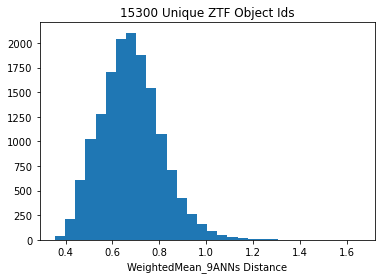

In [249]:
# 10 largest mean 9 ANN distances distances (most different)
plt.hist(ann_dist_all_df[dist_col], 
         bins=np.linspace(np.min(ann_dist_all_df[dist_col]), 
                          np.max(ann_dist_all_df[dist_col]), 31), density=False);
plt.xlabel(dist_col+' Distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');

In [250]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of distance
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.6794546253521007
Scatter median: 0.6730218489061703
Scatter std: 0.13062128765144485
Scatter max: 1.6532873958349228
Scatter min: 0.35466017946600914


Most anomalous: ZTF19aaeyltm


# Smallest

### AGN/QSOs have smallest dist
### some stars, SN

In [251]:
ann_dist_all_df[dist_col].nsmallest(10)

key_0
ZTF19aalfali    0.354660
ZTF19abpkoqf    0.362678
ZTF21abowuqe    0.363101
ZTF19aascqjr    0.363331
ZTF18acefnew    0.364699
ZTF19aasfayj    0.375994
ZTF21aarwlht    0.377206
ZTF19abyhwmw    0.377453
ZTF18abixqaz    0.379146
ZTF19abkcmga    0.379355
Name: WeightedMean_9ANNs, dtype: float64

In [252]:
# 10 smallest  distances (most similar)
for ztfid in list(ann_dist_all_df[dist_col].nsmallest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF19aalfali

https://alerce.online/object/ZTF19abpkoqf

https://alerce.online/object/ZTF21abowuqe

https://alerce.online/object/ZTF19aascqjr

https://alerce.online/object/ZTF18acefnew

https://alerce.online/object/ZTF19aasfayj

https://alerce.online/object/ZTF21aarwlht

https://alerce.online/object/ZTF19abyhwmw

https://alerce.online/object/ZTF18abixqaz

https://alerce.online/object/ZTF19abkcmga

https://alerce.online/object/ZTF17aaayial

https://alerce.online/object/ZTF20abfphyf

https://alerce.online/object/ZTF19abjsfkq

https://alerce.online/object/ZTF18aaxwzcl

https://alerce.online/object/ZTF19abkfquy

https://alerce.online/object/ZTF20aawoixs

https://alerce.online/object/ZTF20abgbufk

https://alerce.online/object/ZTF20abnfjgj

https://alerce.online/object/ZTF19abgfufo

https://alerce.online/object/ZTF18aceitok

https://alerce.online/object/ZTF19abctkyp

https://alerce.online/object/ZTF18abxeckg

https://alerce.online/object/ZTF19acmvzsy

https://ale

In [253]:
dataset_ref = dataset_bank[dataset_bank.index == list(ann_dist_all_df[dist_col].nsmallest(10).index)[0]]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[0.48149202052523926 -0.02215211261471224 0.3968009484189517
 0.3834250075037337 -0.5263120014004287 -0.0307767585906238
 -0.10488615407675596 0.1137684713231792 0.43867252186178946
 0.41774446875105814 -0.09719527381938602 0.17227277894230864
 -0.024122816638632937 -0.005024571742235849 0.017385710693118617
 -0.04073137637783156 0.08743944266727188 0.028675904943701053
 0.08862633798611319 -0.01609892412916086 0.010955877517684547
 -0.03633997673646427 0.04278654505234403 -0.10669636980462241
 0.4359515183152347]
ZTF ID name (ref) ZTF19aalfali
https://alerce.online/object/ZTF19aalfali
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aalfali		Yes_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=267.06517947+55.23697266&filter=color

ANN=1	https://alerce.online/object/ZTF19aascqjr		No_TNS		None		z=-99.0			d=0.2595	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=218.41909158+60.96265845&filter=color

ANN=2	https://alerce.online/object/ZTF19aavkcfv		No_TNS		Non

In [254]:
# dist ANN=1 and mean of first 9 ANN are roughly same (SN, CV, Mira, etc). 
# Not as many SN (but otherwise similar as above) in weighted (fibonacci) average of first 9 ANN.
# Separation will come down to host gal info

MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787